<a href="https://colab.research.google.com/github/reitezuz/18NES2-2025/blob/main/week_10/text_classification_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Natural Language Processing Example - Sentiment Classification

IMDB Dataset is a dataset for binary sentiment classification (positive or negative reviews). It contains a set of 25,000 highly polar movie reviews for training and 25,000 for testing.

 - http://ai.stanford.edu/~amaas/data/sentiment/
 - https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Based on: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter14_text-classification.ipynb


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"



### Download and extract the zip file with the data

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup
!rm -r aclImdb/val

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  14.1M      0  0:00:05  0:00:05 --:--:-- 16.4M
rm: cannot remove 'aclImdb/val': No such file or directory


In [ ]:
import os, pathlib, shutil, random, keras

imdb_extract_dir = pathlib.Path("aclImdb")
for path in imdb_extract_dir.glob("*/*"):
    if path.is_dir():
        print(path)

aclImdb/train/pos
aclImdb/train/neg
aclImdb/test/pos
aclImdb/test/neg


## Prepare the data:
1. divide the train folder into two folders: train and val


In [ ]:
import os, pathlib, shutil, random

# Create the directory with the validation data
base_dir = pathlib.Path("aclImdb")
#base_dir = pathlib.Path("data")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

In [ ]:
for path in base_dir.glob("*/*"):
    if path.is_dir():
        print(path)

aclImdb/train/pos
aclImdb/train/neg
aclImdb/test/pos
aclImdb/test/neg
aclImdb/val/pos
aclImdb/val/neg


2. create the datasets from the directories

In [ ]:
import keras

batch_size = 32

# Create the training, validation and testing data sets:
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


## The bag of words approach - 1. Unigrams



### Preprocess the data
- Configure the TextVectorization layer to return bag-of-words
- Define the number of tokens to keep (skip the unimportant ones): choosing the 20,000 most important tokens is a reasonable choice.
- Note: Vectorization always run on the CPU (we set num_parallel calls).

In [ ]:
max_tokens = 20000

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot", # "tf_idf" "counts"
    split = "whitespace"
)

# create vocabulary based on the daataset
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=8)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=8)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=8)

for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(
[12.899571    2.789394    0.71043456 ...  0.          0.
  0.        ], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
x, y = next(binary_1gram_train_ds.as_numpy_iterator())
print(x.shape, y.shape)


(32, 20000) (32,)


In [ ]:
# observe the vocabulary
text_vectorization.get_vocabulary()[0:12]

['[UNK]',
 np.str_('the'),
 np.str_('a'),
 np.str_('and'),
 np.str_('of'),
 np.str_('to'),
 np.str_('is'),
 np.str_('in'),
 np.str_('it'),
 np.str_('i'),
 np.str_('this'),
 np.str_('that')]

In [ ]:
text_vectorization.get_vocabulary()[100:108]

[np.str_('too'),
 np.str_('characters'),
 np.str_('think'),
 np.str_('watch'),
 np.str_('two'),
 np.str_('many'),
 np.str_('being'),
 np.str_('character')]

### Define a MLP (or a simple linear classifier)

In [ ]:
from keras import layers


def get_mlp_model(max_tokens=20000, hidden_dim=None):
    inputs = keras.Input(shape=(max_tokens,))
    if hidden_dim is not None: # one hidden layer
        x = layers.Dense(hidden_dim, activation="relu")(inputs)
        x = layers.Dropout(0.5)(x)
    else: # simple linear classifier (no hidden layer)
        x = inputs
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_mlp_model()
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │        20,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,001 (78.13 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# plot the training progress:
def plot_history(history):
    history_dict = history.history
    print(history_dict.keys())

    from matplotlib import pyplot as plt

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
import pandas as pd
results_df = pd.DataFrame()

### Train a MLP model on bag of words (unigrams)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │        20,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,001 (78.13 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7993 - loss: 0.4479 - val_accuracy: 0.8932 - val_loss: 0.2816
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9480 - loss: 0.1679 - val_accuracy: 0.8964 - val_loss: 0.2697
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9731 - loss: 0.1090 - val_accuracy: 0.9008 - val_loss: 0.2722
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9852 - loss: 0.0772 - val_accuracy: 0.8986 - val_loss: 0.2840
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9916 - loss: 0.0569 - val_accuracy: 0.8952 - val_loss: 0.3006
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9952 - loss: 0.0429 - val_accuracy: 0.8946 - val_loss: 0.3189
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9972 - loss: 0.0327 - val_accuracy: 0.8916 - val_loss: 0.3381
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


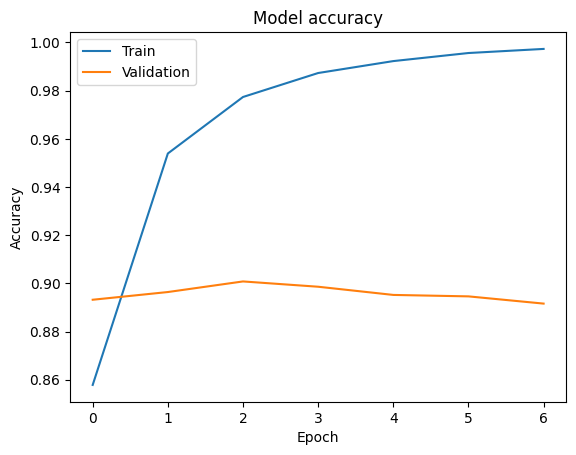

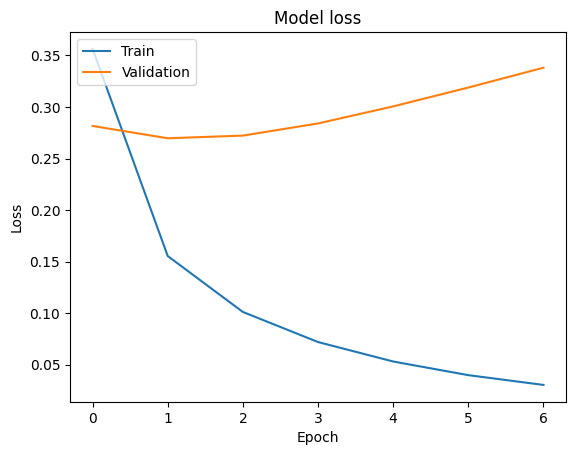

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9758 - loss: 0.1073
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8966 - loss: 0.2827
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8722 - loss: 0.3313
Train acc: 0.983
Val acc: 0.896
Test acc: 0.872


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,MLP BoW,"20000 tokens, None",0.096456,0.269659,0.328851,0.98275,0.8964,0.87172,<built-in function max>,15.30728


In [ ]:
hidden_dim = None
max_epochs = 10
model_name = "bow_unigram.keras"

###############################################
# Define the model architecture:
model = get_mlp_model(max_tokens, hidden_dim)
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(binary_1gram_train_ds)
val_loss, val_acc = model.evaluate(binary_1gram_val_ds)
test_loss, test_acc = model.evaluate(binary_1gram_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : "MLP BoW",
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
results_df.to_csv("results.csv", index=False)
results_df

### Apply the model to new texts

In [ ]:
# create an inference model:
import keras
model = keras.models.load_model("models/bow_unigram.keras")
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
], dtype=tf.string)
predictions = inference_model(raw_text_data)
for i in range(len(raw_text_data)):
    print(f"text {i}: {float(predictions[i] * 100):.2f} percent positive")

text 0: 34.20 percent positive
text 1: 53.83 percent positive
text 2: 73.24 percent positive
text 3: 57.21 percent positive


## The bag of words approach - 2. Bigrams

### Preprocess the data
- configure the TextVectorization layer to return binary encoded bigrams

In [ ]:
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    ngrams=2,
    max_tokens=max_tokens,
    output_mode="multi_hot",
)

text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

for inputs, targets in binary_2gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1 1 1 ... 0 0 0], shape=(20000,), dtype=int64)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
x, y = next(binary_2gram_train_ds.as_numpy_iterator())
print(x.shape, y.shape)

(32, 20000) (32,)


In [ ]:
text_vectorization.get_vocabulary()[100:108]

[np.str_('great'),
 np.str_('him'),
 np.str_('most'),
 np.str_('dont'),
 np.str_('it was'),
 np.str_('one of'),
 np.str_('made'),
 np.str_('for the')]

### Train a MLP model on binary encoded bigrams

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │        20,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,001 (78.13 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8042 - loss: 0.4999 - val_accuracy: 0.8982 - val_loss: 0.3051
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9227 - loss: 0.2532 - val_accuracy: 0.9060 - val_loss: 0.2620
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9451 - loss: 0.1929 - val_accuracy: 0.9076 - val_loss: 0.2454
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9611 - loss: 0.1565 - val_accuracy: 0.9102 - val_loss: 0.2382
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9710 - loss: 0.1305 - val_accuracy: 0.9082 - val_loss: 0.2359
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9791 - loss: 0.1106 - val_accuracy: 0.9056 - val_loss: 0.2365
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9843 - loss: 0.0946 - val_accuracy: 0.9054 - val_loss: 0.2389
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9878 - loss: 0.0815 - val_accuracy: 0

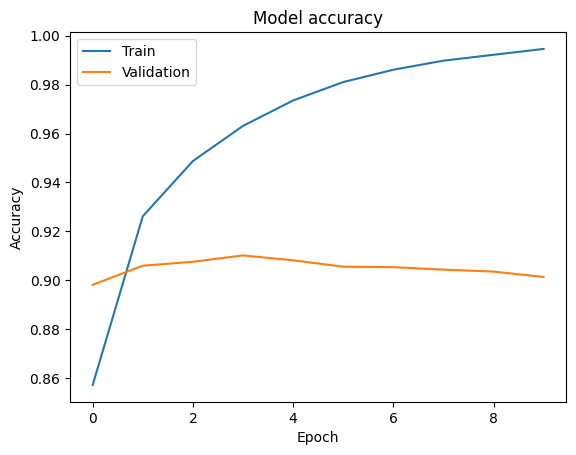

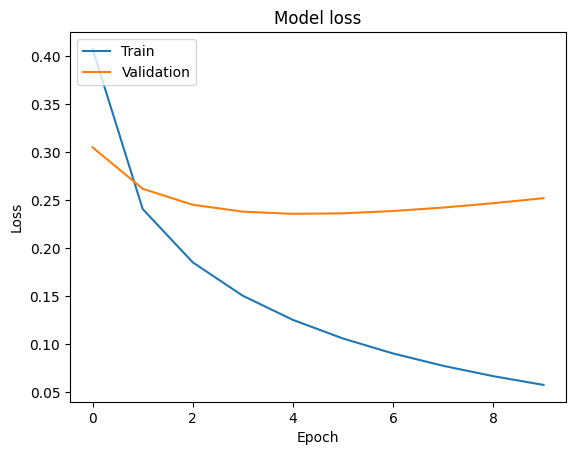

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9810 - loss: 0.1087
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9103 - loss: 0.2354
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8997 - loss: 0.2585
Train acc: 0.985
Val acc: 0.908
Test acc: 0.901


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,MLP BoW,"20000 tokens, None",0.096456,0.269659,0.328851,0.98275,0.8964,0.87172,<built-in function max>,15.307280
1,MLP BoW,"20000 tokens, None",0.102598,0.235941,0.253571,0.98475,0.9082,0.90080,<built-in function max>,28.210042


In [ ]:
hidden_dim = None
max_epochs = 10
model_name = "bow_bigram.keras"

###############################################
# Define the model architecture:
model = get_mlp_model(max_tokens, hidden_dim)
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(binary_2gram_train_ds)
val_loss, val_acc = model.evaluate(binary_2gram_val_ds)
test_loss, test_acc = model.evaluate(binary_2gram_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : "MLP BoW",
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

In [ ]:
# remove the second row from df:
#results_df = results_df.drop(1)
#results_df

### Apply the model to new texts

In [ ]:
# create an inference model:
import keras
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
], dtype=tf.string)
predictions = inference_model(raw_text_data)
for i in range(len(raw_text_data)):
    print(f"text {i}: {float(predictions[i] * 100):.2f} percent positive")

text 0: 19.13 percent positive
text 1: 43.90 percent positive
text 2: 91.86 percent positive
text 3: 70.18 percent positive


__Observation:__ much better results

## Sequential model on one-hot vectors
- the training is very slow and unefficient

In [ ]:

from keras import layers

max_length = 600      # Maximum length of each sequence (longer sequences will be truncated)
max_tokens = 20000    # Number of (most important) tokens

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",                 # Convert text to sequences of integer indices
    output_sequence_length=max_length, # Ensure sequences have the given fixed length
)

# This step analyzes the dataset to create a vocabulary based on the most frequent tokens
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

# Observe the data:
for inputs, targets in int_train_ds:
      print("inputs.shape:", inputs.shape)
      print("inputs.dtype:", inputs.dtype)
      print("targets.shape:", targets.shape)
      print("targets.dtype:", targets.dtype)
      print("inputs:", inputs)
      print("targets:", targets)
      break



inputs.shape: (32, 600)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs: tf.Tensor(
[[  11   19  772 ...    0    0    0]
 [   3  916 1907 ...    0    0    0]
 [  87   19   52 ...    0    0    0]
 ...
 [1388  338    6 ...    0    0    0]
 [ 342    5 2831 ...    0    0    0]
 [  10  287    6 ...    0    0    0]], shape=(32, 600), dtype=int64)
targets: tf.Tensor([1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1], shape=(32,), dtype=int32)


In [ ]:

x, y = next(int_test_ds.as_numpy_iterator())
x.shape



(32, 600)

In [ ]:
hidden_dim = 32
max_epochs = 10
model_name = "one_hot_bidir_lstm.keras"

###############################################
# Define the model architecture:
inputs = keras.Input(shape=(None,), dtype="int64")

# Use Lambda layer to wrap tf.one_hot and specify output_shape
embedded = layers.Lambda(lambda x: tf.one_hot(x, depth=max_tokens),
                        output_shape=(max_length, max_tokens))(inputs)

x = layers.Bidirectional(layers.LSTM(hidden_dim))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(int_train_ds)
val_loss, val_acc = model.evaluate(int_val_ds)
test_loss, test_acc = model.evaluate(int_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : "MLP BoW",
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

In [ ]:
import tensorflow as tf


inputs = keras.Input(shape=(None,), dtype="int64")
# Use Lambda layer to wrap tf.one_hot and specify output_shape
embedded = layers.Lambda(lambda x: tf.one_hot(x, depth=max_tokens),
                        output_shape=(max_length, max_tokens))(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras", save_best_only=True)]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)


#model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 600, 20000)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │       5,128,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,128,513 (19.56 MB)

 Trainable params: 5,128,513 (19.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 224s 357ms/step - accuracy: 0.6302 - loss: 0.6288 - val_accuracy: 0.8216 - val_loss: 0.4322
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 223s 357ms/step - accuracy: 0.8524 - loss: 0.3892 - val_accuracy: 0.8886 - val_loss: 0.2943
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 279s 384ms/step - accuracy: 0.8853 - loss: 0.3096 - val_accuracy: 0.8820 - val_loss: 0.2860
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 245s 356ms/step - accuracy: 0.9096 - loss: 0.2645 - val_accuracy: 0.8822 - val_loss: 0.3949
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 223s 356ms/step - accuracy: 0.9222 - loss: 0.2333 - val_accuracy: 0.8458 - val_loss: 0.4909
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 356ms/step - accuracy: 0.9274 - loss: 0.2099 - val_accuracy: 0.8874 - val_loss: 0.2887
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 356ms/step - accuracy: 0.9390 - loss: 0.1837 - val_accuracy: 0.8784 - val_loss: 0.3142
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 279s 384ms/step - accuracy: 0.9470 -

## Sequential model that uses an Embedding layer trained from scratch
- __Embedding__ layer: https://keras.io/api/layers/core_layers/embedding/

`layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True)`

- we set `mask_zero=True` to let the model ignore padding positions during training  
  (padding tokens with index 0 are not included in the computation of LSTM/GRU states)
- this usually improves performance on variable-length text sequences

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 64)  │  1,280,000 │ input_layer_25[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer_25[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 64)        │     18,816 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ bidirectional_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │         65 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,298,881 (4.95 MB)

 Trainable params: 1,298,881 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 349s 554ms/step - accuracy: 0.6453 - loss: 0.6060 - val_accuracy: 0.8682 - val_loss: 0.3109
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 310s 439ms/step - accuracy: 0.8680 - loss: 0.3201 - val_accuracy: 0.8808 - val_loss: 0.2829
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 436s 621ms/step - accuracy: 0.9049 - loss: 0.2392 - val_accuracy: 0.8796 - val_loss: 0.3353
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 321s 513ms/step - accuracy: 0.9289 - loss: 0.1917 - val_accuracy: 0.8890 - val_loss: 0.3053
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 310s 495ms/step - accuracy: 0.9452 - loss: 0.1521 - val_accuracy: 0.8776 - val_loss: 0.3790
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 281s 449ms/step - accuracy: 0.9549 - loss: 0.1255 - val_accuracy: 0.8580 - val_loss: 0.4669
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 283s 452ms/step - accuracy: 0.9673 - loss: 0.0989 - val_accuracy: 0.8744 - val_loss: 0.3914
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


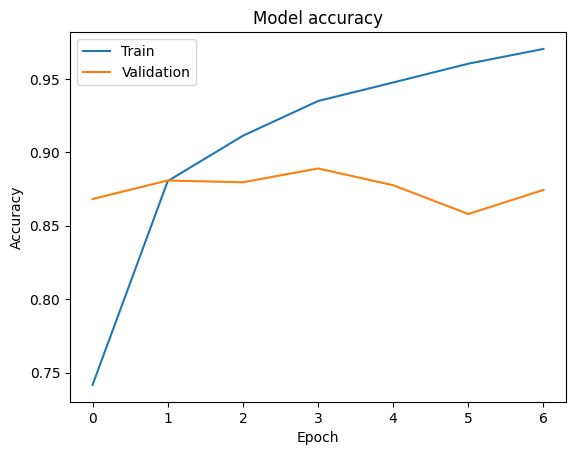

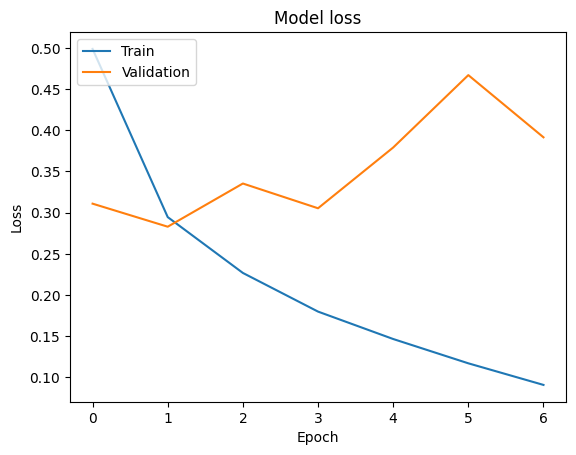

625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9195 - loss: 0.2204
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.8854 - loss: 0.2789
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.8656 - loss: 0.3074
Train acc: 0.928
Val acc: 0.881
Test acc: 0.868


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,MLP BoW,"20000 tokens, None",0.096456,0.269659,0.328851,0.98275,0.8964,0.87172,<built-in function max>,15.307280
1,MLP BoW,"20000 tokens, None",0.102598,0.235941,0.253571,0.98475,0.9082,0.90080,<built-in function max>,28.210042
2,MLP BoW,"20000 tokens, 32",0.205826,0.282889,0.306483,0.92820,0.8808,0.86808,<built-in function max>,2289.008376


In [ ]:
hidden_dim = 32
embedding_dim = 64 #256
max_epochs = 10
model_name = "embeddings_bidir_gru.keras"

###############################################
# Define the model architecture:
inputs = keras.Input(shape=(None,), dtype="int64")

# Add an Embedding layer to convert integer tokens into dense vectors
embedded = layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.GRU(hidden_dim))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=max_epochs,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(int_train_ds)
val_loss, val_acc = model.evaluate(int_val_ds)
test_loss, test_acc = model.evaluate(int_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : "MLP BoW",
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

__Observation:__
- the training is slow (in our case about 40 minutes on google colab CPU)
- the model overfitts early
- the results are worse than for the bigram+MLP approach: most probably because of the limit on sequence length (600 words)

### Apply the model to new data

In [ ]:
# create an inference model:
import keras
inputs = keras.Input(shape=(1,), dtype="string")
model = keras.models.load_model("models/embeddings_bidir_gru.keras")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

import tensorflow as tf
raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
], dtype=tf.string)
predictions = inference_model(raw_text_data)
for i in range(len(raw_text_data)):
    print(f"text {i}: {float(predictions[i] * 100):.2f} percent positive")

text 0: 2.48 percent positive
text 1: 55.16 percent positive
text 2: 97.26 percent positive
text 3: 77.44 percent positive
text 4: 77.33 percent positive


## Sequential model that uses existing pretrained word embeddings
- useful for small datasets

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-12-01 11:27:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-01 11:27:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-01 11:27:55--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Parse the GloVe word-embeddings file
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
# Prepare the GloVe word-embeddings matrix
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Embedding layer
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, None, 100) │  2,000,000 │ input_layer_26[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None)      │          0 │ input_layer_26[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 64)        │     25,728 │ embedding_5[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ bidirectional_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1)         │         65 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,025,793 (7.73 MB)

 Trainable params: 25,793 (100.75 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 305s 483ms/step - accuracy: 0.6012 - loss: 0.6518 - val_accuracy: 0.8196 - val_loss: 0.4121
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 398ms/step - accuracy: 0.8058 - loss: 0.4334 - val_accuracy: 0.8514 - val_loss: 0.3425
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 248s 397ms/step - accuracy: 0.8412 - loss: 0.3654 - val_accuracy: 0.8638 - val_loss: 0.3157
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 413ms/step - accuracy: 0.8557 - loss: 0.3320 - val_accuracy: 0.8732 - val_loss: 0.2996
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 407ms/step - accuracy: 0.8668 - loss: 0.3088 - val_accuracy: 0.8794 - val_loss: 0.2924
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 259s 415ms/step - accuracy: 0.8774 - loss: 0.2863 - val_accuracy: 0.8806 - val_loss: 0.2864
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 409ms/step - accuracy: 0.8884 - loss: 0.2726 - val_accuracy: 0.8834 - val_loss: 0.2860
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 349s 559ms/step - accuracy: 0.8964 -

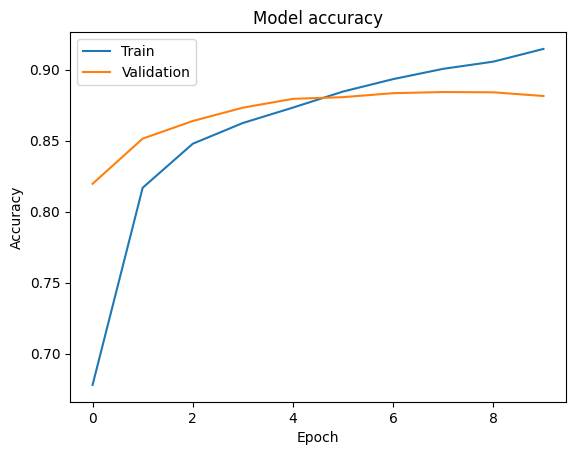

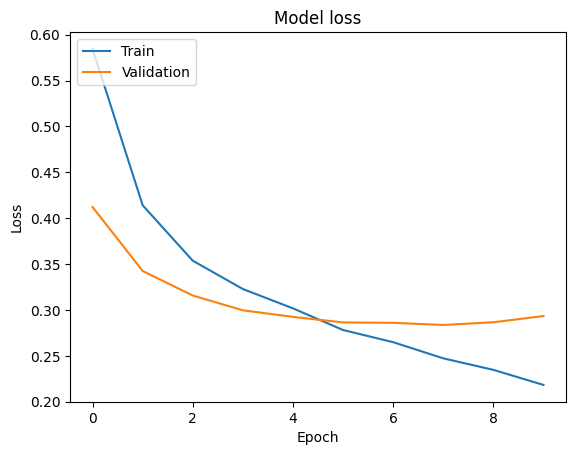

625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 100ms/step - accuracy: 0.9124 - loss: 0.2200
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.8880 - loss: 0.2699
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.8791 - loss: 0.2883
Train acc: 0.919
Val acc: 0.884
Test acc: 0.883


,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,MLP BoW,"20000 tokens, None",0.096456,0.269659,0.328851,0.98275,0.8964,0.87172,<built-in function max>,15.307280
1,MLP BoW,"20000 tokens, None",0.102598,0.235941,0.253571,0.98475,0.9082,0.90080,<built-in function max>,28.210042
2,MLP BoW,"20000 tokens, 32",0.205826,0.282889,0.306483,0.92820,0.8808,0.86808,<built-in function max>,2289.008376
3,MLP BoW,"20000 tokens, 32",0.208911,0.283630,0.283375,0.91885,0.8842,0.88260,<built-in function max>,2811.702257


In [ ]:
hidden_dim = 32
embedding_dim = 64 #256
max_epochs = 10
model_name = "embeddings_glove_gru.keras"

###############################################
# Define the model architecture:
inputs = keras.Input(shape=(None,), dtype="int64")

# Add an Embedding layer to convert integer tokens into dense vectors
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.GRU(hidden_dim))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=max_epochs,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(int_train_ds)
val_loss, val_acc = model.evaluate(int_val_ds)
test_loss, test_acc = model.evaluate(int_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : "MLP BoW",
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

### Apply the model to new data

In [ ]:
# create an inference model:
import keras
inputs = keras.Input(shape=(1,), dtype="string")
model = keras.models.load_model("models/embeddings_glove_gru.keras")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

import tensorflow as tf
raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
], dtype=tf.string)
predictions = inference_model(raw_text_data)
for i in range(len(raw_text_data)):
    print(f"text {i}: {float(predictions[i] * 100):.2f} percent positive")

text 0: 8.95 percent positive
text 1: 65.04 percent positive
text 2: 99.42 percent positive
text 3: 36.98 percent positive
text 4: 66.17 percent positive


__Observations:__ worse results than training embedding from scratch for domain-specific sentences (e.g., last two)

## Sequential model that uses uses word embeddings pretrained by a CBOW model trained from scratch

In [93]:
imdb_vocabulary = text_vectorization.get_vocabulary()
tokenize_no_padding = keras.layers.TextVectorization(
    vocabulary=imdb_vocabulary,
    split="whitespace",
    output_mode="int",
)

#### Preprocess the data for the CBOW model
- create windows of tokens from the training data, where each window consists of context words and a target word.
- The `window_data` function generates sliding windows of tokens, and `split_label`
 separates the context (bag) from the target (label) word within each window.
- The dataset is then mapped through a tokenizer, windowed, and split into (context, target) pairs.

In [ ]:
import tensorflow as tf

context_size = 4
window_size = 9

def window_data(token_ids):
    num_windows = tf.maximum(tf.size(token_ids) - context_size * 2, 0)
    windows = tf.range(window_size)[None, :]
    windows = windows + tf.range(num_windows)[:, None]
    windowed_tokens = tf.gather(token_ids, windows)
    return tf.data.Dataset.from_tensor_slices(windowed_tokens)

def split_label(window):
    left = window[:context_size]
    right = window[context_size + 1 :]
    bag = tf.concat((left, right), axis=0)
    label = window[4]
    return bag, label

dataset = keras.utils.text_dataset_from_directory(
    imdb_extract_dir / "train", batch_size=None
)
dataset = dataset.map(lambda x, y: x, num_parallel_calls=8)
dataset = dataset.map(tokenize_no_padding, num_parallel_calls=8)
dataset = dataset.interleave(window_data, cycle_length=8, num_parallel_calls=8)
dataset = dataset.map(split_label, num_parallel_calls=8)



Found 20000 files belonging to 2 classes.


### Train the CBOW  model

In [92]:
hidden_dim = 64
inputs = keras.Input(shape=(2 * context_size,))
cbow_embedding = layers.Embedding(
    max_tokens,
    hidden_dim,
)
x = cbow_embedding(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(max_tokens, activation="sigmoid")(x)
cbow_model = keras.Model(inputs, outputs)
cbow_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

cbow_model.summary(line_length=80)

dataset = dataset.batch(1024).cache()
cbow_model.fit(dataset, epochs=4)



Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)       │ (None, 8)                │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ embedding_8 (Embedding)           │ (None, 8, 64)            │     1,280,000 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ global_average_pooling1d_2        │ (None, 64)               │             0 │
│ (GlobalAveragePooling1D)          │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_30 (Dense)                  │ (None, 20000)            │     1,300,000 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 2,580,000 (9.84 MB)

 Trainable params: 2,580,000 (9.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
17565/17565 ━━━━━━━━━━━━━━━━━━━━ 1770s 101ms/step - loss: 6.7250 - sparse_categorical_accuracy: 0.0767
Epoch 2/4
    1/17565 ━━━━━━━━━━━━━━━━━━━━ 29:44 102ms/step - loss: 5.5267 - sparse_categorical_accuracy: 0.1445

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17565/17565 ━━━━━━━━━━━━━━━━━━━━ 1707s 97ms/step - loss: 6.0425 - sparse_categorical_accuracy: 0.1185
Epoch 3/4
    1/17565 ━━━━━━━━━━━━━━━━━━━━ 34:00 116ms/step - loss: 5.2443 - sparse_categorical_accuracy: 0.1289

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17565/17565 ━━━━━━━━━━━━━━━━━━━━ 1765s 100ms/step - loss: 5.8402 - sparse_categorical_accuracy: 0.1292
Epoch 4/4
17565/17565 ━━━━━━━━━━━━━━━━━━━━ 1712s 97ms/step - loss: 5.7217 - sparse_categorical_accuracy: 0.1353


#### Using the pretrained embedding for classification

In [ ]:
gru_dim = 32
embedding_dim = 64 #256
max_epochs = 10
model_name = "embeddings_cbow_gru.keras"

###############################################
# Define the model architecture:
inputs = keras.Input(shape=(max_length,))
lstm_embedding = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    mask_zero=True,
)
x = lstm_embedding(inputs)
x = layers.Bidirectional(layers.GRU(gru_dim))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs, outputs, name="gru_with_cbow")

lstm_embedding.embeddings.assign(cbow_embedding.embeddings)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

################################################
# Train the model
import keras, time
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=5, )
]

start_time = time.time()
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=max_epochs,
          callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

train_loss, train_acc = model.evaluate(int_train_ds)
val_loss, val_acc = model.evaluate(int_val_ds)
test_loss, test_acc = model.evaluate(int_test_ds)

print(f"Train acc: {train_acc:.3f}")
print(f"Val acc: {val_acc:.3f}")
print(f"Test acc: {test_acc:.3f}")

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
new_entry = {
    "Model Name" : "MLP BoW",
    "Details" : str(max_tokens) + " tokens, " + str(hidden_dim),
    "Train Loss" : train_loss,
    "Val Loss" : val_loss,
    "Test Loss" : test_loss,
    "Train Acc" : train_acc,
    "Val Acc" : val_acc,
    "Test Acc" : test_acc,
    "Epochs": max,
    "Time (s)": time_fit
}

###############################
if results_df.empty or "results_df" not in globals():
    results_df = pd.DataFrame([new_entry])
else:
    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# save the dataframe
results_df.to_csv("results.csv", index=False)
results_df

In [4]:
import pandas as pd
results_df = pd.read_csv("results.csv")
results_df

,Model Name,Details,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc,Epochs,Time (s)
0,MLP BoW,"20000 tokens, None",0.096456,0.269659,0.328851,0.98275,0.8964,0.87172,<built-in function max>,15.307280
1,MLP BoW,"20000 tokens, None",0.102598,0.235941,0.253571,0.98475,0.9082,0.90080,<built-in function max>,28.210042
2,MLP BoW,"20000 tokens, 32",0.205826,0.282889,0.306483,0.92820,0.8808,0.86808,<built-in function max>,2289.008376
3,MLP BoW,"20000 tokens, 32",0.208911,0.283630,0.283375,0.91885,0.8842,0.88260,<built-in function max>,2811.702257
4,MLP BoW,"20000 tokens, 64",0.118822,0.293420,0.333058,0.96050,0.8886,0.87640,<built-in function max>,3249.341905


In [96]:
# create an inference model:
import keras
inputs = keras.Input(shape=(1,), dtype="string")
model = keras.models.load_model("models/embeddings_cbow_gru.keras")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

import tensorflow as tf
raw_text_data = tf.constant([
    ["That was an awful movie, I hate it."],
    ["Not worth seeing."],
    ["That was an excellent movie, I love it. Best movie ever."],
    ["I was shocked. The movie was too short. Can't wait to see it again"],
    ["I was shocked. Such an unexpected ending! Can't wait to see it again"],
], dtype=tf.string)
predictions = inference_model(raw_text_data)
for i in range(len(raw_text_data)):
    print(f"text {i}: {float(predictions[i] * 100):.2f} percent positive")

text 0: 0.44 percent positive
text 1: 80.69 percent positive
text 2: 99.56 percent positive
text 3: 90.34 percent positive
text 4: 97.46 percent positive


In [ ]:
inputs = keras.Input(shape=(max_length,))
lstm_embedding = layers.Embedding(
    input_dim=max_tokens,
    output_dim=hidden_dim,
    mask_zero=True,
)
x = lstm_embedding(inputs)
x = layers.Bidirectional(layers.GRU(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_cbow")

lstm_embedding.embeddings.assign(cbow_embedding.embeddings)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks,
)


test_loss, test_acc = model.evaluate(int_test_ds)
test_acc



## Simple Transformer model trained from scratch on word embedding

### Transformer encoder implemented as a subclassed Layer

In [ ]:
import tensorflow as tf
import keras
from keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Define and train the Transformer model

In [ ]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", #"rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, None, 256)           │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, None, 256)           │         543,776 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,664,033 (21.61 MB)

 Trainable params: 5,664,033 (21.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.6440 - loss: 0.7220 - val_accuracy: 0.8534 - val_loss: 0.3210
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.8707 - loss: 0.3100 - val_accuracy: 0.8876 - val_loss: 0.2767
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9334 - loss: 0.1687 - val_accuracy: 0.8796 - val_loss: 0.3829
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.9693 - loss: 0.0783 - val_accuracy: 0.8758 - val_loss: 0.4916
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9785 - loss: 0.0573 - val_accuracy: 0.8648 - val_loss: 0.6165
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.9870 - loss: 0.0357 - val_accuracy: 0.8740 - val_loss: 0.6323
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.9929 - loss: 0.0203 - val_accuracy: 0.8584 - val_loss: 0.7629
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9924 - loss: 0.0210 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8748 - loss: 0.3145
Test acc: 0.871


## Simple Transformer model trained from scratch on positional embedding

Implement positional embedding as a subclassed layer

In [ ]:
class CustomMaskingLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return layers.Lambda(lambda x: tf.cast(tf.math.not_equal(x, 0), dtype=tf.bool))(inputs)


    def compute_mask(self, inputs, mask=None):
        return self.call(inputs)

    def get_config(self):
        config = super().get_config()
        return config

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim, mask_zero=True) ## added
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions


    def compute_mask(self, inputs, mask=None):
        #return None
        masking_layer = CustomMaskingLayer()
        return masking_layer(inputs)
        return layers.Lambda(lambda x: tf.cast(tf.math.not_equal(x, 0), dtype=tf.bool))(inputs)
        return tf.not_equal(inputs, 0)
        #return tf.cast(inputs != 0, dtype=tf.bool)
        #return tf.math.not_equal(inputs, 0)
        # Updated: Use TensorFlow compatible boolean mask creation
        mask_layer = layers.Lambda(lambda x: tf.cast(x != 0, dtype=tf.bool))
        return mask_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

Combine the Transformer encoder with positional embedding

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim, mask_zero=True) ## added
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    '''
    def compute_mask(self, inputs, mask=None):
        #return None
        return tf.not_equal(inputs, 0)
        #return tf.cast(inputs != 0, dtype=tf.bool)
        #return tf.math.not_equal(inputs, 0)
        # Updated: Use TensorFlow compatible boolean mask creation
        mask_layer = layers.Lambda(lambda x: tf.cast(x != 0, dtype=tf.bool))
        return mask_layer(inputs)
    '''
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [ ]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam",    #"rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)          │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_embedding_12              │ (None, None, 256)           │       5,273,600 │
│ (PositionalEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_9                │ (None, None, 256)           │         543,776 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,817,633 (22.19 MB)

 Trainable params: 5,817,633 (22.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 67ms/step - accuracy: 0.6770 - loss: 0.6177 - val_accuracy: 0.8740 - val_loss: 0.3075
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 65ms/step - accuracy: 0.9201 - loss: 0.2083 - val_accuracy: 0.8828 - val_loss: 0.2945
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9565 - loss: 0.1149 - val_accuracy: 0.8798 - val_loss: 0.3603
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9736 - loss: 0.0793 - val_accuracy: 0.8806 - val_loss: 0.4752
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9870 - loss: 0.0445 - val_accuracy: 0.8772 - val_loss: 0.5917
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9889 - loss: 0.0362 - val_accuracy: 0.8750 - val_loss: 0.5825
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.9872 - loss: 0.0416 - val_accuracy: 0.8720 - val_loss: 0.6951
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9892 - loss: 0.0374 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'positional_embedding_12', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.8665 - loss: 0.3295
Test acc: 0.865


## Finetuning a Pretrained Transformer

In [97]:
## Loading a pretrained Transformer

import keras_hub

tokenizer = keras_hub.models.Tokenizer.from_preset("roberta_base_en")
backbone = keras_hub.models.Backbone.from_preset("roberta_base_en")

print(tokenizer("The quick brown fox"))
backbone.summary(line_length=80)

tf.Tensor([  133  2119  6219 23602], shape=(4,), dtype=int32)


Model: "roberta_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape      ┃     Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ token_ids             │ (None, None)      │           0 │ -                  │
│ (InputLayer)          │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ embeddings            │ (None, None, 768) │  38,996,736 │ token_ids[0][0]    │
│ (TokenAndPositionEmb… │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ embeddings_layer_norm │ (None, None, 768) │       1,536 │ embeddings[0][0]   │
│ (LayerNormalization)  │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ embeddings_dropout    │ (None, None, 768) │           0 │ embeddings_layer_… │
│ (Dropout)             │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ padding_mask          │ (None, None)      │           0 │ -                  │
│ (InputLayer)          │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_0   │ (None, None, 768) │   7,087,872 │ embeddings_dropou… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_1   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_2   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_3   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_4   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_5   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_6   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_7   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_8   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_9   │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │                   │             │ padding_mask[0][0] │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ transformer_layer_10  │ (None, None, 768) │   7,087,872 │ transformer_layer… │
│ (TransformerEncoder)  │      

 Total params: 124,052,736 (473.22 MB)

 Trainable params: 124,052,736 (473.22 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# Load and process the data
from keras.utils import text_dataset_from_directory

batch_size = 16
train_dir = "aclImdb/train"
val_dir = "aclImdb/val"
test_dir = "aclImdb/test"

train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

def preprocess(text, label):
    packer = keras_hub.layers.StartEndPacker(
        sequence_length=512,
        start_value=tokenizer.start_token_id,
        end_value=tokenizer.end_token_id,
        pad_value=tokenizer.pad_token_id,
        return_padding_mask=True,
    )
    token_ids, padding_mask = packer(tokenizer(text))
    return {"token_ids": token_ids, "padding_mask": padding_mask}, label

preprocessed_train_ds = train_ds.map(preprocess)
preprocessed_val_ds = val_ds.map(preprocess)
preprocessed_test_ds = test_ds.map(preprocess)

next(iter(preprocessed_train_ds))

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


({'token_ids': <tf.Tensor: shape=(16, 512), dtype=int32, numpy=
  array([[    0,   100,    33, ...,     1,     1,     1],
         [    0,   100,   421, ...,     1,     1,     1],
         [    0,  4688,  2679, ...,     1,     1,     1],
         ...,
         [    0,   100,   437, ...,     1,     1,     1],
         [    0,  6179,    20, ...,     9,   358,     2],
         [    0, 25496,   728, ...,     1,     1,     1]], dtype=int32)>,
  'padding_mask': <tf.Tensor: shape=(16, 512), dtype=bool, numpy=
  array([[ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ..., False, False, False]])>},
 <tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int32)>)

In [ ]:
# Create and finetune the model

inputs = backbone.input
x = backbone(inputs)
x = x[:, 0, :]
x = layers.Dropout(0.1)(x)
x = layers.Dense(768, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
classifier = keras.Model(inputs, outputs)



classifier.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
classifier.fit(
    preprocessed_train_ds,
    validation_data=preprocessed_val_ds,
    epochs = 1
)

classifier.evaluate(preprocessed_test_ds)